<a href="https://colab.research.google.com/github/balszeg/Deep_learning_uniproject/blob/main/Semester_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone #1 ##
Cloning the chosen git repository for the dataset.

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


Importing the necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split

Setting the path for the images, and reading there names in a list.

In [ ]:
image_path ='/content/covid-chestxray-dataset/images'
image_names=os.listdir(image_path)
print(image_names)

['000005-5-b.jpg', 'covid-19-caso-82-1-8.png', '2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg', '1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg', '41591_2020_819_Fig1_HTML.webp-day10.png', '41182_2020_203_Fig4_HTML.jpg', '2fc8a7c61c76f13ee7f9306b44e792_jumbo.jpg', '16689_2_1.png', 'ec083e35.jpg', '000003-7.jpg', '1-s2.0-S0085253820303616-gr1_lrg-a.png', '86ee6e6c.jpg', '000003-3.jpg', '16689_2_2.png', 'aspiration-pneumonia-5-day27.jpg', 'pneumocystis-jiroveci-pneumonia-4-L.png', '19073f37.jpg', '296_2020_4584_Fig2_HTML-a.png', 'd009d61f.jpg', '1-s2.0-S1931312820301852-gr1_lrg-b.png', 'f5c69a3d9dcf2d5d4e54d0d080b666_jumbo.jpeg', 'c601f50d.jpg', '16744_2_1.jpg', '16745_5_3.png', 'radiol.2020201160.fig3b.jpeg', '000002-8.jpg', '000002-268.jpg', '4fed5061.jpg', '16755_1_1.jpg', '1-s2.0-S2214250920300834-gr1_lrg-c.png', 'afaa068f1.png', 'all14238-fig-0001-m-c.jpg', '10.1016-slash-j.jhin.2020.03.036.png', '000007-2.png', 'ee2d1bf6.jpg', '000001-2.png', 'kjr-21-e24-g002-l-b.jpg', '78b60346d1b3bce85353

Read the labels for the learning from a CSV file and put the names of the X-rays into an another list with the same order.


In [ ]:
x_raw_name=[] # the names of the pictures
y_label=[] # pcr test: True=+, False=-
images = [] # array for the actual images

with open('/content/covid-chestxray-dataset/metadata.csv') as csv_file: #load the csv from the session storage
    csv_reader = csv.reader(csv_file, delimiter=',') # ',' is the separating character
    line_count = 0 # line counter
    for row in csv_reader:
        if line_count == 0:
            # print("Images, PCR_test result") #the 0.th row is just a header
            line_count = 1
        else:
            if row[23] in image_names: # check if we have the x-ray image for this diagnosis
                if row[5]=='': # negative covid test
                  y_label.append(False)
                if row[5]=='Y': #positive covid test
                  y_label.append(True)
                if row[5]=='Y' or row[5]=='':
                  x_raw_name.append(row[23])
                  img = cv2.imread(image_path + '/' + x_raw_name[-1],0) # load the image
                  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) # resize the image to 512*512
                  images.append(img)
                  line_count += 1
    # print(f'Processed {line_count} lines.')
    print(f'{line_count-1} examples')
    images = np.asarray(images)
    y_label = np.asarray(y_label)
    # print(images.shape)


719 examples


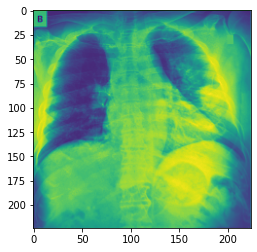

In [ ]:
#lets check some data now: all the images are 512*512 now
plt.imshow(images[1]) # the most of the images are "front"

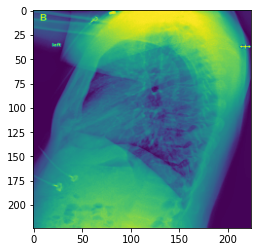

In [ ]:
plt.imshow(images[25]) #some of them has taken from the side.

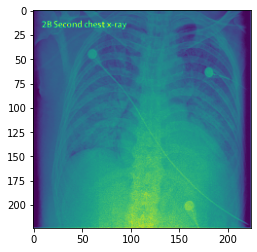

In [ ]:
plt.imshow(images[8]) # in some picture we can see wires and other medical equipments, it will might be hard to ignore and separate them from the important data: the pneumonia, during the deep learning
#the labels in the pictures also can cause some issue

Normalizing the images

In [ ]:
# "normalize" the images
normalized = images.astype(float)
for i in range(len(normalized)):
  normalized[i] = normalized[i]/255 # all pixel value between 0 and 1


In [ ]:
print(len(normalized[:,0,0]))
print(len(normalized[0,:,0]))
print(len(normalized[0,0,:]))

triplechanel=np.zeros([len(normalized[:,0,0]),len(normalized[0,:,0]),len(normalized[0,0,:]),3])

print(triplechanel.shape)
triplechanel[:,:,:,0], triplechanel[:,:,:,1], triplechanel[:,:,:,2] = normalized, normalized, normalized
len(triplechanel)

719
224
224
(719, 224, 224, 3)


719

In [ ]:
print(len(y_label)) #size of the database, we don't use the images where the pcr test wasn't sure

719


Splitting the data into training, testing and validation sets

In [ ]:
# split the data into train, test, and validation arrays
x_train, x_2, y_train, y_2 = train_test_split(triplechanel, y_label, test_size=0.3, shuffle=True) # 70% of the data is the train data, 30% is for test and validation
x_valid, x_test, y_valid, y_test = train_test_split(x_2, y_2, test_size=0.33, shuffle=True) # Two thirds of the remaining 33% is the validation data and the remaining is for test
# shape of the arrays
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(503, 224, 224, 3)
(144, 224, 224, 3)
(72, 224, 224, 3)
(503,)
(144,)
(72,)


#Milestone 2

Building and training of a self-designed CNN 

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (8, 8), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [ ]:
x_train = x_train.reshape(x_train.shape[0],224,224,3)
x_valid = x_valid.reshape(x_valid.shape[0],224,224,3)
x_test = x_test.reshape(x_test.shape[0],224,224,3)

In [ ]:
model.fit(x_train, y_train, epochs=20, batch_size=30, validation_data=(x_valid, y_valid))

Epoch 1/20
17/17 [==============================] - 1s 83ms/step - loss: 0.6484 - accuracy: 0.5845 - val_loss: 0.6535 - val_accuracy: 0.5764
Epoch 2/20
17/17 [==============================] - 1s 62ms/step - loss: 0.6058 - accuracy: 0.6103 - val_loss: 0.6520 - val_accuracy: 0.5694
Epoch 3/20
17/17 [==============================] - 1s 62ms/step - loss: 0.5765 - accuracy: 0.6600 - val_loss: 0.6038 - val_accuracy: 0.6389
Epoch 4/20
17/17 [==============================] - 1s 61ms/step - loss: 0.5643 - accuracy: 0.6720 - val_loss: 0.6618 - val_accuracy: 0.6319
Epoch 5/20
17/17 [==============================] - 1s 62ms/step - loss: 0.6892 - accuracy: 0.6978 - val_loss: 0.9104 - val_accuracy: 0.5486
Epoch 6/20
17/17 [==============================] - 1s 62ms/step - loss: 0.5060 - accuracy: 0.7078 - val_loss: 0.7030 - val_accuracy: 0.5903
Epoch 7/20
17/17 [==============================] - 1s 61ms/step - loss: 0.4773 - accuracy: 0.7336 - val_loss: 0.7436 - val_accuracy: 0.5625
Epoch 8/20
17

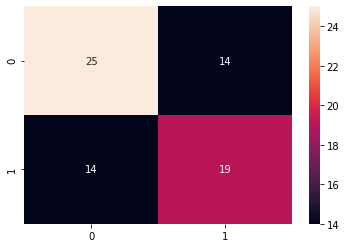

In [ ]:
predict = model.predict(x_test) # predict the output for all test images
for i in range(len(predict)):
  if predict[i] > 0.5:
    predict[i] = 1
  else:
    predict[i] = 0
conf_matrix = confusion_matrix(y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap

Transfer learning a pre-trained VGG19 model

In [ ]:
def VGG19_Model():
  # loading the VGG19 network, ensuring the head FC-layer sets are left off
  baseModel = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(output)
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(256, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
  # place the head FC model on top of the base model
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [ ]:
model = VGG19_Model()
print("Compiling model:")

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 40
BATCHSIZE = 32 

# defining the optimizer
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# compiling the model
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# printing the model structure
print(model.summary())

Compiling model:
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 5

In [ ]:
STEP_TRAIN = len(x_train) // BATCHSIZE
STEP_VALID = len(x_valid) // BATCHSIZE
checkpointer=ModelCheckpoint(filepath='weights.h5',save_best_only=True,verbose=1) #We save the best model with checkpointer
modelHistory = model.fit(x_train, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=1,
                         validation_data=(x_valid, y_valid), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_VALID,callbacks=checkpointer)

Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.5063
Epoch 00001: val_loss improved from inf to 0.68219, saving model to weights.h5
15/15 [==============================] - 2s 122ms/step - loss: 0.8471 - accuracy: 0.5063 - val_loss: 0.6822 - val_accuracy: 0.5312
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.5393
Epoch 00002: val_loss did not improve from 0.68219
15/15 [==============================] - 1s 93ms/step - loss: 0.7705 - accuracy: 0.5393 - val_loss: 0.7175 - val_accuracy: 0.5078
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5223
Epoch 00003: val_loss improved from 0.68219 to 0.66221, saving model to weights.h5
15/15 [==============================] - 2s 109ms/step - loss: 0.6970 - accuracy: 0.5223 - val_loss: 0.6622 - val_accuracy: 0.5938
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.5648
Epoch 00004: val_lo

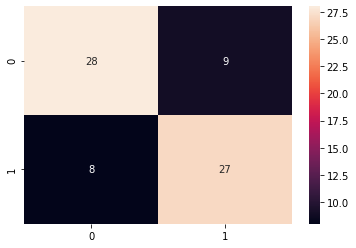

In [ ]:
#we are saving the best model
from keras.models import load_model
model = load_model('weights.h5') #we load the best model from the previos learning, we will go on with that

predict = model.predict(x_test) # predict the output for all test images
for i in range(len(predict)):
  if predict[i] > 0.5:
    predict[i] = 1
  else:
    predict[i] = 0
conf_matrix = confusion_matrix(y_test, predict) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap